In [16]:
import requests
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ParseError
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/atharvajain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/atharvajain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Change this directory path based on where you have stored the Corpus dataset
dir_path = "/Users/atharvajain/Downloads/NTCIR-12_MathIR_Wikipedia_Corpus/MathTagArticles"
# Change this for the number of articles the number of articles to be used as training data
num_articles = 1000

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [19]:
from bs4 import BeautifulSoup
import re

def fetch_all_disciplines():

    disciplines = []
    labels = []
    
    url = 'https://arxiv.org/category_taxonomy'
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')

    for h4 in soup.find_all('h4'):
        full_text = h4.get_text(strip=True)
        match = re.search(r'\((.*?)\)', full_text)
        labels.append(match.group(1))

        code = h4.contents[0].strip()
        disciplines.append(code)
    
    return disciplines[1:], labels[1:]

dis, label = fetch_all_disciplines()

In [20]:
def group_by_prefix(disciplines):
    # Create a dictionary to hold groups by their prefixes
    grouped = {}

    physics_prefixes = [
        'astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th',
        'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'quant-ph'
    ]

    # Iterate over each category
    for category in disciplines:
        # Split the category to get the prefix
        prefix = category.split('.')[0]

        if any(category.startswith(physics_prefix) for physics_prefix in physics_prefixes):
            prefix = 'physics'
        
        # If the prefix is not in the dictionary, add it with an empty list
        if prefix not in grouped:
            grouped[prefix] = []
        
        # Append the category to the appropriate list
        grouped[prefix].append(category)
    
    # Convert the dictionary values to a list of lists
    grouped_list = list(grouped.values())
    
    return grouped_list

grouped_categories = group_by_prefix(dis)
# grouped_categories[0].remove('cs.FL')
print(grouped_categories)

[['cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY'], ['econ.EM', 'econ.GN', 'econ.TH'], ['eess.AS', 'eess.IV', 'eess.SP', 'eess.SY'], ['math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV', 'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT', 'math.KT', 'math.LO', 'math.MG', 'math.MP', 'math.NA', 'math.NT', 'math.OA', 'math.OC', 'math.PR', 'math.QA', 'math.RA', 'math.RT', 'math.SG', 'math.SP', 'math.ST'], ['astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other', 'cond-mat.quant-gas', 'cond-mat.

In [21]:
subject_categories = {'cs': len(grouped_categories[0]),
    'econ':len(grouped_categories[1]),
    'eess':len(grouped_categories[2]),
    'math':len(grouped_categories[3]),
    'phys':len(grouped_categories[4]),
    'q-bio':len(grouped_categories[5]),
    'q-fin':len(grouped_categories[6]),
    'stat':len(grouped_categories[7])}

print(subject_categories)

{'cs': 40, 'econ': 3, 'eess': 4, 'math': 32, 'phys': 51, 'q-bio': 10, 'q-fin': 9, 'stat': 6}


In [22]:
def fetch_articles(category_code, max_results):
    # Define the base URL and query parameters for the arXiv API request
    physics_prefixes = [
        'astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th',
        'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'quant-ph'
    ]
    subject = category_code.split('.')[0]
    total_articles = 0
    if subject in physics_prefixes:
        total_articles = max_results // subject_categories['phys']
    else:
        total_articles = max_results // subject_categories.get(subject, 1) 


    base_url = "http://export.arxiv.org/api/query?"
    query_params = {
        "search_query": f"cat:{category_code}",
        "start": 0,
        "max_results": total_articles # Need to modify this into a math formula
    }
    # final = ""
    res = []
    # Send the request to the arXiv API
    response = requests.get(base_url, params=query_params)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the XML response
        try:
            root = ET.fromstring(response.content)      
        except ParseError as e:
            print(f"XML ParseError in response from category {category_code}: {e}")
            return res  # Return the empty list for this batch and continue with next
        
        # Namespace dictionary to simplify references in the find functions
        ns = {'ns': 'http://www.w3.org/2005/Atom'}

        # Extract and print the primary category and abstract for each article
        for entry in root.findall('ns:entry', ns):
            # The primary category is an attribute of the category element
            primary_category = entry.find('ns:category', ns).attrib['term']
            title = entry.find('ns:title', ns).text

            abstract = entry.find('ns:summary', ns).text.strip()

            filtered_abstract = remove_stopwords(abstract)
            
            # final += filtered_abstract
            res.append(filtered_abstract)
        
        # return final
        return res

    else:
        return "Failed to retrieve data from arXiv API"

In [24]:
fetched_data = fetch_articles(grouped_categories[0][0], num_articles)
orig_select = grouped_categories
grouped_categories[0].pop(0)

# for i in range(1, len(dis)):
#     fetched_data += fetch_articles(dis[i], num_articles)

for i in range(len(grouped_categories)):
    for j in range(len(grouped_categories[i])):
        fetched_data += fetch_articles(grouped_categories[i][j], num_articles) 

In [25]:
def create_labels(num_articles):
    label = []
    
    for i in orig_select:
        for j in i:
            if j.startswith('cs'):
                for _ in range(num_articles // (subject_categories['cs'])):
                    label.append('Computer Science')
            
            elif j.startswith('math') and not j.endswith('-ph'):
                for _ in range(num_articles // subject_categories['math']):
                    label.append('Mathematics')
            
            elif j.startswith('econ'):  
                for _ in range(num_articles // subject_categories['econ']):
                    label.append('Economics')
            
            elif j.startswith('eess'):
                for _ in range(num_articles // subject_categories['eess']):
                    label.append('Electrical Engineering and System Science')
            
            elif j.startswith('q-bio'):
                for _ in range(num_articles // subject_categories['q-bio']):
                    label.append('Quantitative Biology')
            
            elif j.startswith('q-fin'):
                for _ in range(num_articles // subject_categories['q-fin']):
                    label.append('Quantitative Finance')
            
            elif j.startswith('stat'):
                for _ in range(num_articles // subject_categories['stat']):
                    label.append('Statistics')
            
            else:
                physics = ['astro', 'cond', 'gr', 'hep', 'nlin', 'nucl', 'physics', 'quant', 'math']
                
                for k in physics:
                    if j.startswith(k):
                        for _ in range(num_articles // subject_categories['phys']):
                            label.append('Physics')
    
    return label

label = create_labels(num_articles)
label

['Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Sc

In [26]:
import re
def remove_special_chars(text):
    pattern = r"[,.#@^&*!?/><;:|+=%(){}$_\\]"
    text = re.sub(r'\\[a-zA-Z]+(\[[^\]]*\])?(\{[^\}]*\})?', '', text)
    
    # Remove math expressions enclosed in dollar signs
    text = re.sub(r'\$.*?\$', '', text)
    
    # Remove double dollar signs math expressions
    text = re.sub(r'\$\$.*?\$\$', '', text)
    
    # Remove \begin{...} ... \end{...} blocks
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    
    return re.sub(pattern, "", text)

clean_text = []

for category in fetched_data:
    clean_text.append(remove_special_chars(category))

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=5, max_df=0.8, ngram_range=(1, 2))
X = vectorizer.fit_transform(clean_text)
X.shape

(7915, 16679)

In [28]:
if len(label) < X.shape[0]:
    X = X[:len(label),:]
else:
   label = label[:X.shape[0]] 

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_train.nnz / (X_train.shape[0] * X_train.shape[1]))  # Density of the matrix

(6324, 16679)
0.003854263594465712


In [29]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Making predictions
y_pred = clf.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7906388361796332
                                           precision    recall  f1-score   support

                         Computer Science       0.72      0.67      0.69       197
                                Economics       0.78      0.79      0.79       227
Electrical Engineering and System Science       0.83      0.90      0.86       209
                              Mathematics       0.72      0.74      0.73       186
                                  Physics       0.84      0.76      0.80       172
                     Quantitative Biology       0.90      0.83      0.86       211
                     Quantitative Finance       0.83      0.84      0.83       183
                               Statistics       0.71      0.78      0.74       196

                                 accuracy                           0.79      1581
                                macro avg       0.79      0.79      0.79      1581
                             weighted avg       0.79    

In [31]:
# Saving the model
import joblib
joblib.dump(X_test, "X_test.pkl")
joblib.dump(X_test, "y_test.pkl")
joblib.dump(clf, "multinomial_nb_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [9]:
# Loading the model and running the accuracy test with the loaded model
import joblib
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = joblib.load("vectorizer.pkl")
X_test = joblib.load("X_test.pkl")
y_test = joblib.load("y_test.pkl")
clf = joblib.load("multinomial_nb_model.pkl")
y_pred = clf.predict(X_test)

# Evaluating the loaded model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [10]:
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    # Remove unwanted script and style elements
    for script_or_style in soup(["script", "style"]):
        script_or_style.decompose()
    # Get text
    text = soup.get_text(separator=' ')

    words = [word.strip() for word in text.split() if word.strip()]
    first_100_words = ' '.join(words[:100])
    return first_100_words

In [11]:
def predict_html_category(html_content, model, vectorizer):
    text = extract_text_from_html(html_content)
    text_vector = vectorizer.transform([text])
    prediction = model.predict(text_vector)
    return prediction[0]

In [12]:
folder_names = ["wpmath00000"+ "0" + str(f_name) if f_name < 10 else "wpmath00000" + str(f_name) for f_name in range(2, 17)]
disciplines = {
    'Computer Science': [],
    'Economics': [],
    'Mathematics': [],
    'Physics': [],
    'Electrical Engineering and System Science': [],
    'Quantitative Biology': [],
    'Quantitative Finance': [],
    'Statistics': []
}

In [13]:
import pickle

with open("matching_articles.pkl", "rb") as f:
    matching_articles = pickle.load(f)

print(matching_articles)

['Combinatorial_species.html', 'Fresnel_integral.html', 'Fredholm_operator.html']


In [16]:
import os
from bs4 import BeautifulSoup
def read_html_content(folder_name, article_name):
    """
    Reads HTML content from a specific article file inside a folder.

    Args:
        folder_name (str): The folder containing the article.
        article_name (str): The article filename.

    Returns:
        str: The raw HTML content of the article.
    """
    file_path = os.path.join(dir_path, folder_name, article_name)
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            return file.read()  # Return HTML content
    return None  # Return None if file does not exist

# Iterate through folders and find matching articles
for folder in folder_names:
    folder_path = os.path.join(dir_path, folder)

    # Check if folder exists
    if not os.path.exists(folder_path):
        continue

    # Get list of articles in the folder
    folder_articles = os.listdir(folder_path)

    # Check which target articles exist in this folder
    for article in folder_articles:
        if article in matching_articles:
            # Read HTML content
            html_content = read_html_content(folder, article)

            if html_content:  # Ensure content is not None
                predicted_category = predict_html_category(html_content, clf, vectorizer)

                # Ensure the predicted category is valid
                if predicted_category in disciplines:
                    disciplines[predicted_category].append(article)
                else:
                    print(f"⚠ Warning: Unknown category '{predicted_category}' for article {article}")

# Print the categorized articles
for category, articles in disciplines.items():
    print(f"\n📂 {category}:")
    print(articles)


📂 Computer Science:
[]

📂 Economics:
[]

📂 Mathematics:
['Combinatorial_species.html', 'Fredholm_operator.html']

📂 Physics:
[]

📂 Electrical Engineering and System Science:
['Fresnel_integral.html']

📂 Quantitative Biology:
[]

📂 Quantitative Finance:
[]

📂 Statistics:
[]


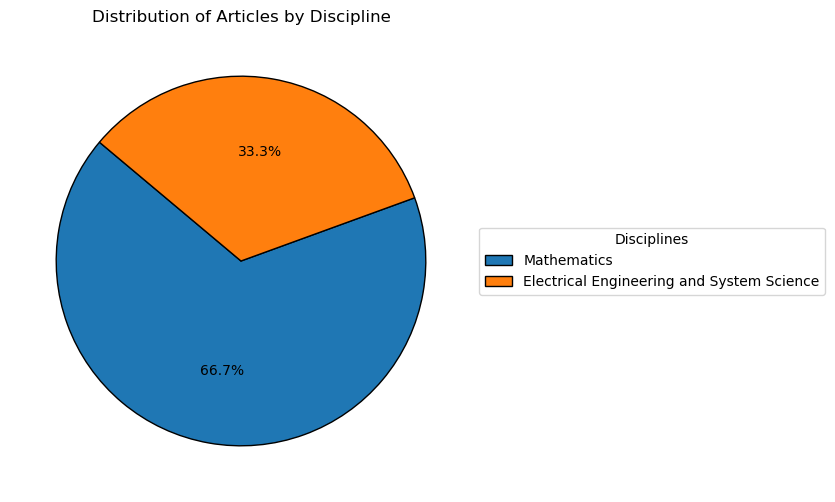

In [24]:
import matplotlib.pyplot as plt

# Count the number of articles in each category
category_counts = {category: len(articles) for category, articles in disciplines.items() if len(articles) > 0}

# Extract labels and values for the pie chart
labels = list(category_counts.keys())
values = list(category_counts.values())

# Create a figure with two sections: one for the pie chart, one for the legend
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(values, startangle=140, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')

# Set the aspect ratio to be equal so the pie chart is circular
ax.set_aspect('equal')

# Add a title
plt.title("Distribution of Articles by Discipline")

# Add a legend on the right side
plt.legend(wedges, labels, title="Disciplines", loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


In [35]:
import socketio
import time

# Create a Socket.IO client
sio = socketio.Client()

# Flask server URL
flask_url = "http://127.0.0.1:5000"

try:
    print("Attempting to connect to Flask-SocketIO server...")
    sio.connect(flask_url)  # Establish connection

    print("Connected! Sending disciplines data...")
    sio.emit('update_disciplines', disciplines)  # Emit event

    # Wait briefly to ensure data is transmitted before disconnecting
    time.sleep(1)

    print("Disciplines data sent successfully!")

except socketio.exceptions.ConnectionError as e:
    print(f"Failed to connect: {e}")

finally:
    sio.disconnect()
    print("Disconnected from server.")

Attempting to connect to Flask-SocketIO server...
Connected! Sending disciplines data...
Disciplines data sent successfully!
Disconnected from server.
